In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from pprint import pprint

import tensorflow as tf
import tensorflow_probability as tfp

from gemlib.util import compute_state
from gemlib.distributions import DiscreteTimeStateTransitionModel
from gemlib.distributions import UniformInteger
from gemlib.distributions import UniformKCategorical

from chain_binomial_rippler import chain_binomial_rippler

tfd = tfp.distributions

## Basic SIR model

In [2]:
stoichiometry = np.array([[-1, 1, 0],
                          [0, -1, 1]],
                         dtype=np.float32)
init_state = np.array([[999.0, 1.0, 0.0]], dtype=np.float32)

def hazard_fn(t, state):
    si = 0.5 * state[..., 1] / tf.reduce_sum(state, axis=-1)
    ir = tf.constant([0.14])
    return [si, ir]

model = DiscreteTimeStateTransitionModel(transition_rates=hazard_fn, 
                                         initial_state=init_state, 
                                         initial_step=0,
                                         time_delta=1.0,
                                         num_steps=70,
                                         stoichiometry=stoichiometry)

2022-01-19 12:33:01.071066: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-01-19 12:33:01.071139: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: diamond
2022-01-19 12:33:01.071154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: diamond
2022-01-19 12:33:01.071378: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 465.19.1
2022-01-19 12:33:01.071443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 465.19.1
2022-01-19 12:33:01.071457: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 465.19.1
2022-01-19 12:33:01.072591: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

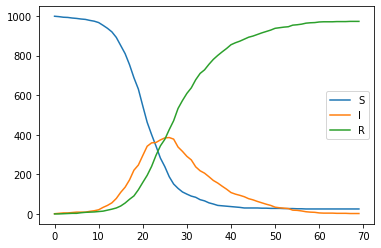

In [3]:
events = model.sample()
state = compute_state(initial_state=init_state, events=events, stoichiometry=stoichiometry)

plt.plot(state[0,...,0], label="S")
plt.plot(state[0,...,1], label="I")
plt.plot(state[0,...,2], label="R")
plt.legend()

# A sampling model

We assume that on each day, we sample 50 individuals from the population.  Let $z_t$ be the number of removal events on day $t$, such that the observed number of new cases is
$$y_t \sim \mbox{Binomial}(z_t, q_t)$$
where $0 < q < 1$ is the detection probability (e.g. sensitivity of a test, or reporting rate).

In [4]:
observation_process = tfd.Independent(
    distribution=tfd.Binomial(total_count=events[...,1],
                              probs=0.5),
    reinterpreted_batch_ndims=1
) # MxT

In [5]:
observed_cases = observation_process.sample()

# Run the Chain Binomial Rippler

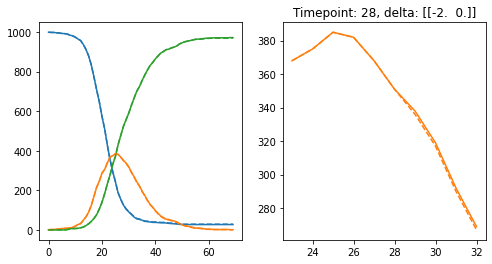

In [7]:
new_events, info = chain_binomial_rippler(model, events)
new_state = compute_state(initial_state=init_state, events=new_events, stoichiometry=model.stoichiometry)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].plot(state[0,...,0], color='C0', label='S original')
ax[0].plot(state[0,...,1], color='C1', label='I original')
ax[0].plot(state[0,...,2], color='C2', label='R original')
ax[0].plot(new_state[0,...,0], '--', color='C0', label='S new')
ax[0].plot(new_state[0,...,1], '--', color='C1', label='I new')
ax[0].plot(new_state[0,...,2], '--', color='C2', label='R new')
lower = np.clip(info['timepoint'] - 5, 0, None)
upper = np.clip(lower + 10, None, state.shape[-2])
ax[1].plot(range(lower, upper), state[0, lower:upper, 1], color='C1')
ax[1].plot(range(lower, upper), new_state[0, lower:upper, 1], '--', color='C1')
_ = plt.title(f"Timepoint: {info['timepoint']}, delta: {info['delta']}")


# Proposal video

In the following video, we iteratively apply `update_trajectory` to the SI events, and look for random walk behaviour of the overall stochastic process trajectory. 

In [8]:
def make_chart_func(initial_events, model):
    
    fig, ax = plt.subplots()
    lineS, = ax.plot([], color='C0', label='S')
    lineI, = ax.plot([], color='C1', label='I')
    lineR, = ax.plot([], color='C2', label='R')
    ax.set_xlim(0, initial_events.shape[-2])
    ax.set_ylim(0, 1100)
    
    events = initial_events
    
    def chartfunc(t):
        nonlocal events
        events, info = chain_binomial_rippler(model, events)
        ax.set_title(f"Frame: {t}, t_idx: {info['timepoint']}, delta: {info['delta']}")
        new_state = compute_state(initial_state=model.initial_state, 
                                  events=events, 
                                  stoichiometry=model.stoichiometry)
        lineS.set_data((np.arange(new_state.shape[-2]), new_state[0,...,0]))
        lineI.set_data((np.arange(new_state.shape[-2]), new_state[0,...,1]))
        lineR.set_data((np.arange(new_state.shape[-2]), new_state[0,...,2]))   
    return fig, chartfunc

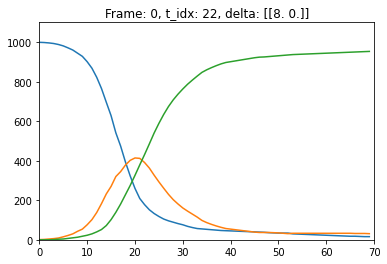

In [9]:
import matplotlib.animation as ani

fig, chartfunc = make_chart_func(events, model)
anim = ani.FuncAnimation(fig, chartfunc, frames=500, interval=40)
HTML(anim.to_html5_video())

# Embed proposal in MCMC algorithm

In [6]:
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.internal import samplers

CBRResults = namedtuple("CBRResults", ["target_log_prob", 
                                       "is_accepted", 
                                       "delta_si", 
                                       "current_state_t", 
                                       "prob_t", 
                                       "new_si_events_t", 
                                       "timepoint", 
                                       "seed"])

class CBRKernel(tfp.mcmc.TransitionKernel):
    
    def __init__(self, target_log_prob_fn, model, name=None):
        
        self._target_log_prob_fn = target_log_prob_fn
        self._model = model
        
        name = mcmc_util.make_name(
                name, "CBRKernel", ""
            )

        self._parameters = dict(
            target_log_prob_fn=target_log_prob_fn,
            model=model,
            name=name,
        )

    @property
    def is_calibrated(self):
        return True
    
    @property
    def target_log_prob(self):
        return self._target_log_prob_fn
    
    @property
    def model(self):
        return self._model
    
    @property
    def name(self):
        return self._parameters.name

    def one_step(self, current_state, previous_results, seed=None):
        
        with tf.name_scope("CBRKernel/one_step"):
            seed = samplers.sanitize_seed(seed, salt="cbr_kernel")
        
            proposed_state, proposal_trace = chain_binomial_rippler(model, current_state, seed=seed)
        
            proposed_target_log_prob = self.target_log_prob(proposed_state)
        
            delta_logp = proposed_target_log_prob - previous_results.target_log_prob
        
            def accept():
                return proposed_state, CBRResults(target_log_prob=proposed_target_log_prob,
                                                  is_accepted=tf.constant(True),
                                                  delta_si=proposal_trace['delta'],
                                                  current_state_t=proposal_trace['current_state_t'],
                                                  prob_t=proposal_trace['prob_t'],
                                                  new_si_events_t=proposal_trace['new_si_events_t'],
                                                  timepoint=proposal_trace['timepoint'],
                                                  seed=seed)

            def reject():
                return current_state, CBRResults(target_log_prob=previous_results.target_log_prob,
                                                 is_accepted=tf.constant(False),
                                                 delta_si=proposal_trace['delta'],
                                                 current_state_t=proposal_trace['current_state_t'],
                                                 prob_t=proposal_trace['prob_t'],
                                                 new_si_events_t=proposal_trace['new_si_events_t'],
                                                 timepoint=proposal_trace['timepoint'],
                                                 seed=seed)
        
            u = tf.math.log(tfd.Uniform().sample())
            return tf.cond(u < delta_logp,
                           accept,
                           reject)
    
    def bootstrap_results(self, current_state):
        with tf.name_scope("CBRKernel/bootstrap_results"):
            return CBRResults(target_log_prob=self.target_log_prob(current_state),
                              is_accepted=tf.constant(False),
                              delta_si=tf.zeros((current_state.shape[-3], current_state.shape[-1]), current_state.dtype),
                              current_state_t=tf.zeros([current_state.shape[-3], self.model.stoichiometry.shape[-1]], current_state.dtype),
                              prob_t=tf.zeros([1], dtype=current_state.dtype),
                              new_si_events_t=tf.zeros([1], current_state.dtype),
                              timepoint=tf.constant(0, dtype=tf.int32),
                              seed=samplers.zeros_seed(),
                             )

In [7]:
def tlp_fn(current_events):
    observation_process = tfd.Binomial(total_count=current_events[...,1],
                                       probs=0.5)
    return tf.reduce_sum(observation_process.log_prob(observed_cases))

kernel = CBRKernel(target_log_prob_fn=tlp_fn, model=model, name='MyKernel')

pkr = kernel.bootstrap_results(events)

In [13]:
@tf.function
def sample():
    return tfp.mcmc.sample_chain(num_results=10000, 
                                 current_state=tf.convert_to_tensor(events, name="initial_state"),
                                 kernel=kernel)

samples, results = sample()
print("Acceptance:", np.mean(results.is_accepted))

/home/jewellcp/Documents/Projects/bp_add_delete/.venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance: 0.8421


## Plot traces

''

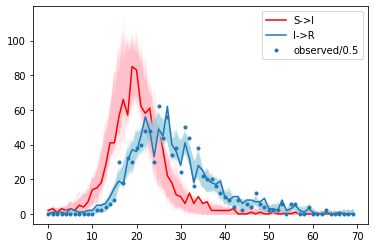

In [31]:
plt.plot(samples[::20, 0, :, 0].numpy().T, alpha=0.05, color='pink')
plt.plot(events[0, :, 0].numpy(), color='red', label="S->I")
plt.plot(samples[::20, 0, :, 1].numpy().T, alpha=0.05, color='lightblue')
plt.plot(events[0, :, 1].numpy(), color='C0', label="I->R")
plt.plot(range(samples.shape[-2]), observed_cases[0]*2, '.', label='observed/0.5')
plt.legend()
;

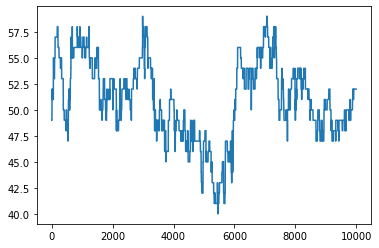

In [19]:
# Traceplot of number of I->R events at time 0 
plt.plot(samples[:, 0, 25, 1])

Calculate the proportion of proposals resulting in no move, i.e. $\Delta z_t = 0$

In [22]:
np.mean(results.delta_si[:, 0, 0] == 0.0)

0.2843

but the acceptance rate for moves where $\delta_{si} \ne 0$ is reasonably high

In [24]:
np.mean(results.is_accepted[results.delta_si[:, 0, 0] != 0])

0.7793768338689395

__Conclusion__: We may need a way of creating a bigger initial perturbation.

In [25]:
import pandas as pd

In [26]:
resdf = pd.DataFrame({'timepoint': results.timepoint.numpy(), 
                      'prob_t': results.prob_t[:, 0].numpy(), 
                      'delta_si': results.delta_si[:, 0, 0], 
                      'current_state': results.current_state_t[:,0,0],
                      'new_events': results.new_si_events_t[:,0],
                     })

In [27]:
resdf['var'] = resdf['current_state']*resdf['prob_t']*(1-resdf['prob_t'])

In [28]:
resdf[resdf['delta_si']==0.0]

,timepoint,prob_t,delta_si,current_state,new_events,var
4,61,0.002995,0.0,24.0,0.0,0.071676
9,59,0.006479,0.0,23.0,0.0,0.148049
10,55,0.011434,0.0,24.0,0.0,0.271282
11,4,0.003494,0.0,990.0,2.0,3.446881
13,65,0.003992,0.0,23.0,0.0,0.091450
...,...,...,...,...,...,...
9981,59,0.038249,0.0,15.0,0.0,0.551795
9984,68,0.036806,0.0,11.0,0.0,0.389960
9986,2,0.000500,0.0,999.0,0.0,0.499155
9992,38,0.083323,0.0,22.0,1.0,1.680364
